In [44]:
try:
  import yfinance
except ImportError:
    !pip install yfinance
try:
  import xgboost
except ImportError:
    !pip install xgboost    
    

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np

# Descargar los datos del IPC
ipc_data = yf.download('^MXX', start='2000-01-01', end='2024-03-15')

# Calcular los retornos diarios
ipc_data['Return'] = ipc_data['Close'].pct_change().dropna()

# Filtrar los datos de entrenamiento y prueba
train_data = ipc_data['2000-01-01':'2018-12-31']
test_data = ipc_data['2019-01-01':'2019-12-31']

# Extraer los retornos
train_returns = train_data['Return'].dropna()
test_returns = test_data['Return'].dropna()


[*********************100%%**********************]  1 of 1 completed


In [46]:

# Calcular los retornos diarios
train_returns = calculate_daily_returns(train_data['Close'])
test_returns = calculate_daily_returns(test_data['Close'])


In [47]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X_train, y_train = create_sequences(train_returns.values, seq_length)
X_test, y_test = create_sequences(test_returns.values, seq_length)


In [48]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Crear los DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Entrenar el modelo
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Hacer predicciones
y_pred = bst.predict(dtest)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')


Error Cuadrático Medio (MSE): 7.165417684879386e-05


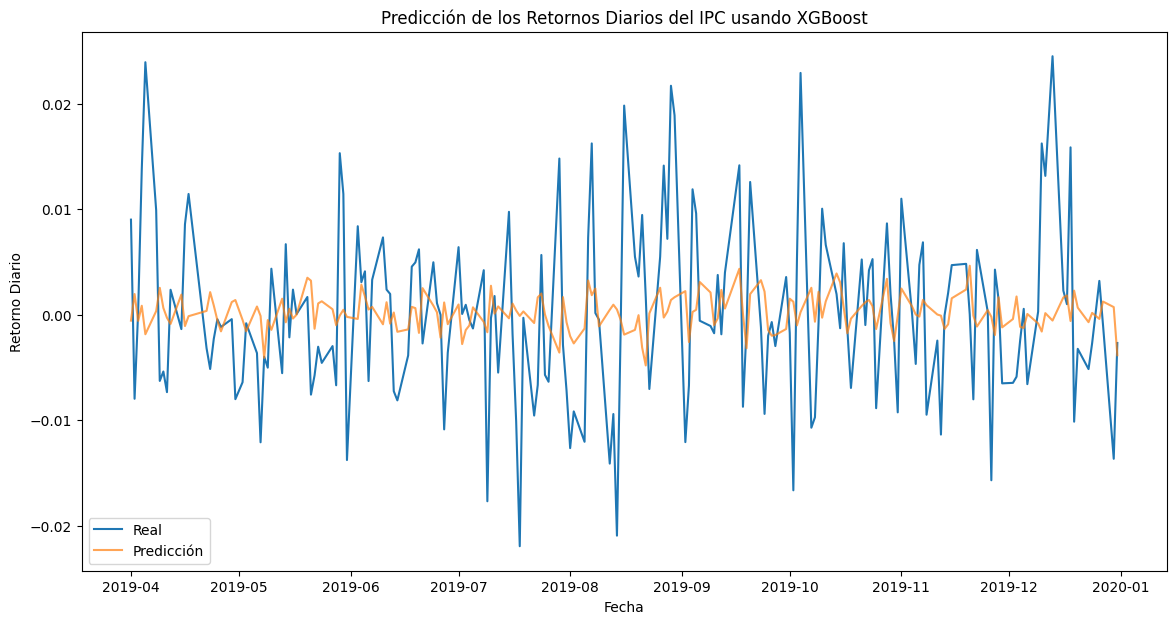

In [49]:
import matplotlib.pyplot as plt

# Convertir los datos de prueba a un DataFrame para facilitar la visualización
test_dates = test_data.index[(seq_length+1):]
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred}, index=test_dates)

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción', alpha=0.7)
plt.title('Predicción de los Retornos Diarios del IPC usando XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario')
plt.legend()
plt.show()
